# Лабораторная работа №3
Группа 3530903/70301  
Ижко Георгий, Шергалис Донат, Сидорова Елена

### 100,000 UK Used Car Data set
https://www.kaggle.com/adityadesai13/used-car-dataset-ford-and-mercedes


1. Выбрать набор данных для своей группы: <br>
    3530203_70101: Audi <br>
    3530203_70102: BMW <br>
    **3530903_70301: Ford** <br>
    3530903_70302: Mercedes<br>
    
2. Разбить данные на тренировочные и тестовые (70% на 30%, random_state=10).
3. Попытаться обучить регрессии c лучшим качеством. 


In [1]:
import pandas as pd
import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

np.set_printoptions(precision=3)
pd.set_option('precision', 3)


In [2]:
auto_data = pd.read_csv("data/ford.csv", delimiter=',\s*', engine='python')
auto_data

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,Fiesta,2017,12000,Automatic,15944,Petrol,150,57.7,1.0
1,Focus,2018,14000,Manual,9083,Petrol,150,57.7,1.0
2,Focus,2017,13000,Manual,12456,Petrol,150,57.7,1.0
3,Fiesta,2019,17500,Manual,10460,Petrol,145,40.3,1.5
4,Fiesta,2019,16500,Automatic,1482,Petrol,145,48.7,1.0
...,...,...,...,...,...,...,...,...,...
17960,Fiesta,2016,7999,Manual,31348,Petrol,125,54.3,1.2
17961,B-MAX,2017,8999,Manual,16700,Petrol,150,47.1,1.4
17962,B-MAX,2014,7499,Manual,40700,Petrol,30,57.7,1.0
17963,Focus,2015,9999,Manual,7010,Diesel,20,67.3,1.6


# Анализ выбросов

In [3]:
auto_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17965 entries, 0 to 17964
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         17965 non-null  object 
 1   year          17965 non-null  int64  
 2   price         17965 non-null  int64  
 3   transmission  17965 non-null  object 
 4   mileage       17965 non-null  int64  
 5   fuelType      17965 non-null  object 
 6   tax           17965 non-null  int64  
 7   mpg           17965 non-null  float64
 8   engineSize    17965 non-null  float64
dtypes: float64(2), int64(4), object(3)
memory usage: 1.2+ MB


Нет null значений

In [4]:
auto_data.describe()

,year,price,mileage,tax,mpg,engineSize
count,17965.000,17965.000,17965.000,17965.000,17965.000,17965.000
mean,2016.867,12279.756,23363.631,113.335,57.907,1.351
std,2.050,4741.383,19472.115,62.010,10.126,0.432
min,1996.000,495.000,1.000,0.000,20.800,0.000
25%,2016.000,8999.000,9987.000,30.000,52.300,1.000
50%,2017.000,11291.000,18243.000,145.000,58.900,1.200
75%,2018.000,15299.000,31064.000,145.000,65.700,1.500
max,2060.000,54995.000,177644.000,580.000,201.800,5.000


* `year=2060` -- явная ошибка
* `price=495` -- реалистична
* `price=54995` --  стоит проверить
* `mpg=201.8` -- вероятно выброс (кол-во миль на галон)
* `mileage=177644` -- реалистичный пробег
* `tax=0` -- наверное, корректное значение
* `engineSize=0` -- пустое значение
* `engineSize=5` -- стоит проверить

### Выбросы engineSize

In [5]:
def get_engine_by_size(size, df = auto_data):
    return df[df.engineSize == size]

zero_engine = get_engine_by_size(0)
print(len(zero_engine), ":", set(zero_engine.fuelType))

51 : {'Hybrid', 'Petrol', 'Diesel'}


Попахивает неправдой.

In [6]:
auto_data.drop(zero_engine.index, inplace=True)

In [7]:
big_engine = get_engine_by_size(5)
set(big_engine.model)

{'Mondeo', 'Mustang'}

Что здесь забыл Mondeo? Выпихиваем.

In [8]:
mondeo_liar = big_engine[big_engine.model == 'Mondeo']
auto_data.drop(mondeo_liar.index, inplace=True)

### Выбросы year

In [9]:
def get_year_over(year = 2021, df = auto_data):
    return df[df.year > year]

from_future = get_year_over()
from_future

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
17726,Fiesta,2060,6495,Automatic,54807,Petrol,205,42.8,1.4


Насколько нам известно, Эммет Браун и Марти МакФлай ездили на DeLorean, а не на Ford Fiesta.   
Можно предположить, что на самом деле там должно быть значение 2006. А можно просто хладнокровно вырвать эту строчку из датасета.

In [10]:
auto_data.drop(from_future.index, inplace=True)

### Выбросы price

In [11]:
def get_price_over(threshold, df = auto_data):
    return df[df.price > threshold]

overprice = get_price_over(50000)
overprice

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
11912,Focus,2018,54995,Manual,11000,Petrol,145,36.7,2.3


Для Фокуса 55к бачинских многовато будет. [Разве что...](https://i.pinimg.com/originals/8a/32/12/8a32122ffae41e0c2d10ebb7ecc8e595.jpg) Но это всё равно выброс. Выбрасываем выброс.

In [12]:
auto_data.drop(overprice.index, inplace=True)

In [13]:
set(get_price_over(40000).model)

{'Mustang'}

Для Мустанга цена похожа на правду.

### Выбросы mpg

In [14]:
def get_mpg_over(threshold, df = auto_data):
    return df[df.mpg > threshold]

high_mpg = get_mpg_over(100)
high_mpg
# print(len(high_mpg), ":", set(high_mpg.model))

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
6153,Kuga,2020,31000,Semi-Auto,10,Hybrid,135,201.8,2.5
6536,Kuga,2020,31991,Semi-Auto,2357,Hybrid,135,201.8,2.5
9220,Kuga,2020,32000,Automatic,10,Hybrid,140,201.8,2.5
12862,Kuga,2020,33500,Automatic,5534,Hybrid,140,201.8,2.5
13730,Kuga,2020,32995,Automatic,11,Hybrid,135,201.8,2.5


<AxesSubplot:>

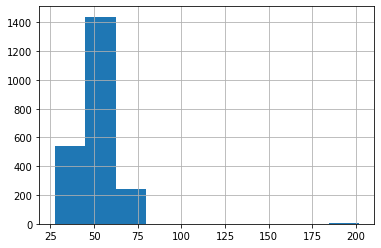

In [15]:
auto_data[auto_data.model == 'Kuga'].mpg.hist()

Реальные значения mpg для Ford Kuga находятся в пределах 60: https://www.honestjohn.co.uk/realmpg/ford/kuga-2013

In [16]:
auto_data.drop(high_mpg.index, inplace=True)

### Выбросы mileage

<AxesSubplot:>

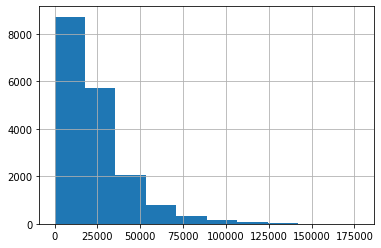

In [17]:
auto_data.mileage.hist()

Распределение выглядит реалистично.

### Проверка результата выброса выбросов:

In [18]:
auto_data.describe()

,year,price,mileage,tax,mpg,engineSize
count,17906.000,17906.000,17906.000,17906.000,17906.000,17906.000
mean,2016.862,12273.357,23380.130,113.327,57.873,1.354
std,2.026,4721.936,19475.536,62.016,9.837,0.426
min,1996.000,495.000,1.000,0.000,20.800,1.000
25%,2016.000,8999.000,9995.250,30.000,52.300,1.000
50%,2017.000,11291.000,18254.500,145.000,58.900,1.200
75%,2018.000,15298.750,31095.250,145.000,65.700,1.500
max,2020.000,49999.000,177644.000,580.000,88.300,5.000


## Анализ значений текстовых полей

In [19]:
# признак  | значения
for col in auto_data[['model', 'transmission', 'fuelType']]:
    values = auto_data[col].unique()
    str_values = str(values)
    if len(str_values) > 300:
        str_values = str_values[:300] + '...'
    print(col, ':', len(values), '\n', str_values, '\n')

model : 23 
 ['Fiesta' 'Focus' 'Puma' 'Kuga' 'EcoSport' 'C-MAX' 'Mondeo' 'Ka+'
 'Tourneo Custom' 'S-MAX' 'B-MAX' 'Edge' 'Tourneo Connect' 'Grand C-MAX'
 'KA' 'Galaxy' 'Mustang' 'Grand Tourneo Connect' 'Fusion' 'Ranger'
 'Streetka' 'Escort' 'Transit Tourneo'] 

transmission : 3 
 ['Automatic' 'Manual' 'Semi-Auto'] 

fuelType : 5 
 ['Petrol' 'Diesel' 'Hybrid' 'Electric' 'Other'] 



### Анализ списка типов топлива

In [20]:
fueltype_counts = auto_data.fuelType.value_counts()
fueltype_counts

Petrol      12130
Diesel       5757
Hybrid         16
Electric        2
Other           1
Name: fuelType, dtype: int64

/usr/local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='fuelType', ylabel='count'>

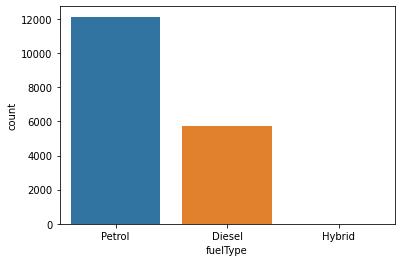

In [40]:
sns.countplot(auto_data.fuelType)

In [22]:
hybrids = auto_data[auto_data.fuelType == 'Hybrid']
set(hybrids.model)

{'Mondeo'}

Mondeo действительно бывают гибридными.

In [23]:
rare_fueltype = auto_data[auto_data.fuelType.isin({'Other', 'Electric'})]
rare_fueltype

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
6385,Mondeo,2016,15975,Automatic,9396,Electric,0,67.3,2.0
11959,Mondeo,2016,15500,Automatic,24531,Electric,0,67.3,2.0
17492,Mondeo,2015,13800,Automatic,19470,Other,0,67.3,2.0


Я не эксперт, но я бы не стал заливать Other в топливный бак Ford Mondeo.  
Зная, что существуют гибридные Mondeo, можем с должной уверенностью заменить эти значения на Hybrid.  
Но проще их дропнуть.

In [24]:
auto_data.drop(rare_fueltype.index, inplace=True)

### Анализ списка моделей

In [25]:
model_counts = auto_data.model.value_counts()
model_counts

Fiesta                   6537
Focus                    4576
Kuga                     2219
EcoSport                 1135
C-MAX                     543
Ka+                       527
Mondeo                    521
B-MAX                     355
S-MAX                     296
Grand C-MAX               247
Galaxy                    228
Edge                      208
KA                        193
Puma                       79
Tourneo Custom             69
Grand Tourneo Connect      59
Mustang                    57
Tourneo Connect            33
Fusion                     16
Streetka                    2
Ranger                      1
Escort                      1
Transit Tourneo             1
Name: model, dtype: int64

/usr/local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='model', ylabel='count'>

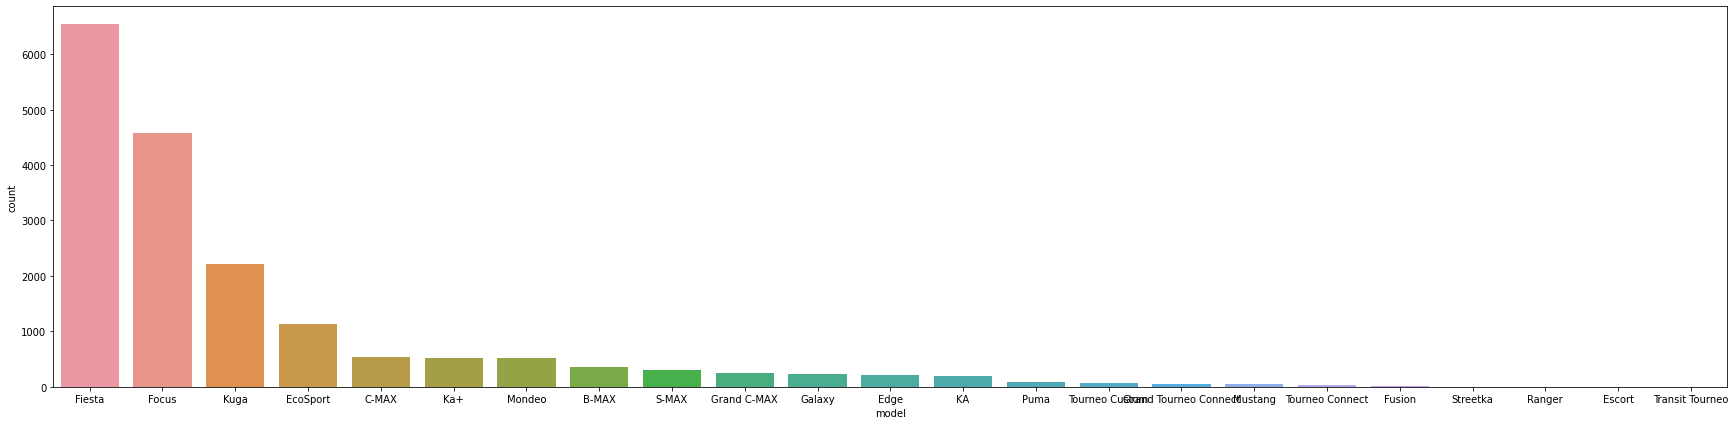

In [26]:
fig, ax = plt.subplots(figsize=(30,7))

sns.countplot(auto_data.model, ax=ax, order=model_counts.index)

In [27]:
rare_models = model_counts[model_counts < 10]
rare_models

Streetka           2
Ranger             1
Escort             1
Transit Tourneo    1
Name: model, dtype: int64

In [28]:
auto_data[auto_data.model.isin(rare_models.index)]

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
13607,Ranger,2013,14495,Manual,88000,Diesel,240,28.3,3.2
14691,Streetka,2005,1999,Manual,63000,Petrol,270,35.3,1.6
16878,Escort,1996,3000,Manual,50000,Petrol,265,34.4,1.8
17080,Streetka,2006,1850,Manual,74055,Petrol,290,35.8,1.6
17741,Transit Tourneo,2014,12450,Manual,19496,Diesel,235,42.2,2.2


Ford Ranger выпускался до 1992 года, в данных указан 2013.  
Остальные данные корректны, однако редкие машины можно считать выбросом и исключить из выборки.  
Пока что ограничимся удалением некорректного Ranger.

In [29]:
extremely_rare = auto_data.model.isin({'Ranger'}) # rare_models.index
auto_data.drop(auto_data[extremely_rare].index, inplace=True)

### Анализ списка

In [30]:

sns.jointplot(x='age', y='credit_amount', data=credit_df, kind='scatter', color='orange')

NameError: name 'credit_df' is not defined

In [ ]:
X, Y = auto_data.drop(['price'], axis=1), auto_data['price']

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=10)